# Setup

## Install the required Python packages

In [1]:
# !pip install pandas
# !pip install sklearn
# !pip install imblearn

## Load essential libraries and Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay)
from imblearn.over_sampling import SMOTE

In [3]:
# Load the Dataset
df = pd.read_csv("GroupProjectDataSet.csv")

# Drop the 'Id' column
df.drop('Id', axis=1, inplace=True)

print(df.shape)

(1460, 80)


# Handling Missing Data and Encoding Categorical Variables

In [4]:
# Replace missing values in numerical columns with the median
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
print(len(numerical_cols))

# fill missing values with median column values
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Identify categorical columns
categorical_cols = df.select_dtypes(exclude=np.number).columns
print(len(categorical_cols))

# Replace missing values in categorical columns 'MiscFeatrue' and 'PoolQC' with 'NA'
df['MiscFeature'] = df['MiscFeature'].fillna('NA')
df['PoolQC'] = df['PoolQC'].fillna('NA')

# Replace missing values in other categorical columns with 'Unknown'
for col in categorical_cols:
    df[col].fillna("Unknown", inplace=True)

# Convert categorical columns to numeric using get_dummies encoding
df = pd.get_dummies(df, columns=categorical_cols)

print(df.shape)
# df.to_csv('GroupProjectDataSetCleaned.csv', index=False)

37
43
(1460, 305)


# Feature Engineering

To improve our models performance, we introduce new features which are combiantions of already existing ones where it could make sense to combine them.

In [5]:
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
df['TotalBath'] = df['FullBath']+ df['BsmtFullBath'] + 0.5 * (df['HalfBath'] + df['BsmtHalfBath'])
df['TotalPorchSF'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
df['HasPool'] = df['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
df['HasGarage'] = df['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
df['HasBasement'] = df['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
df['YearsSinceRemodel'] = df['YearRemodAdd'] - df['YearBuilt']

# Display the DataFrame with the new feature
print(df.shape)

(1460, 313)


## Evaluating Correlations Between Newly Engineered Features

Even though some of the new features do not have a high correlation with 'class' we will not remove any features, as this will be done automatically later.

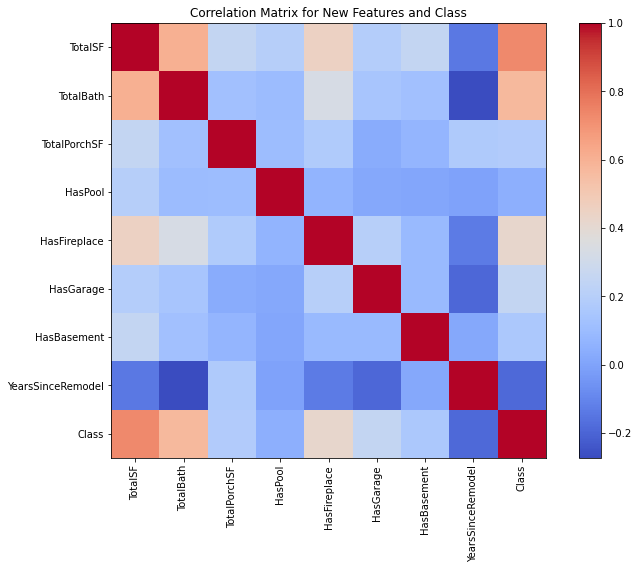

['TotalSF', 'TotalBath', 'HasFireplace']

In [6]:
# List of new features
new_features = [
    'TotalSF', 
    'TotalBath', 
    'TotalPorchSF', 
    'HasPool', 
    'HasFireplace', 
    'HasGarage', 
    'HasBasement', 
    'YearsSinceRemodel'
]

# Include the target variable 'Class'
features = new_features + ['Class']

# Calculate the correlation matrix
corr_matrix = df[features].corr()

# Visualize the correlation matrix using a heatmap-like style from matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)
plt.colorbar()
plt.title('Correlation Matrix for New Features and Class')
plt.show()

['TotalSF', 'TotalBath', 'HasFireplace']

# Dividing the Dataset into Training and Testing Sets

In [7]:
# Split the data into X and y
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Concatenate the training and testing sets to create new DataFrames
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1168, 312)
y_train shape: (1168,)
X_test shape: (292, 312)
y_test shape: (292,)


# Balancing Trainingset through Upsampling

As we can see in below plot, the distribution of class in df_train is very unbalanced. We will address this issue by upsampling the minority classes.

C:\Users\liamt\AppData\Local\Temp/ipykernel_27600/822570099.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


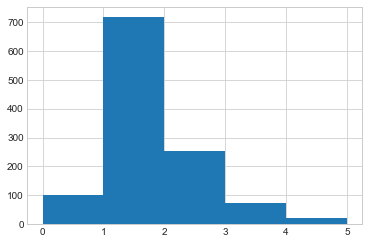

In [8]:
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.size'] = 10
plt.hist(df_train['Class'], bins=[0, 1, 2, 3, 4, 5]);

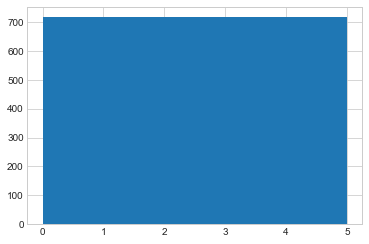

In [9]:
# Handle class imbalance using oversampling with SMOTE
smote_nc = SMOTE(random_state=42)
X_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)
df_train = pd.concat([X_resampled, y_resampled], axis=1)

plt.hist(df_train['Class'], bins=[0, 1, 2, 3, 4, 5]);

# Selecting the Most Significant Features

In [10]:
# Feature selection using Extra Trees Classifier on the resampled training data
model = ExtraTreesClassifier(random_state=42)
model.fit(X_resampled, y_resampled)
importances = model.feature_importances_

# Select top 300 features with highest importance scores
top_features = pd.Series(importances, index=X_resampled.columns).nlargest(300)

# Subset X_resampled and X_test with selected features
X_train_selected = X_resampled[top_features.index]
X_test_selected = X_test[top_features.index]

# Optimizing Hyperparameters for the Random Forest Classifier

In [11]:
# # Random Forest Classifier
# rf = RandomForestClassifier(random_state=42)
# rf_params = {
#     'n_estimators': [1000, 1670, 2000],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [10, 18, 25, None],
#     'min_samples_split': [2, 3, 5],
#     'min_samples_leaf': [1, 2, 4],
#     'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
#     'max_features': ['sqrt', 'log2', None],
#     'max_leaf_nodes': [None, 100, 500, 1000],
#     'min_impurity_decrease': [0.0, 0.1, 0.2],
#     'bootstrap': [True, False],
#     'oob_score': [True, False],
#     'n_jobs': [None, -1],
#     'class_weight': ['balanced', 'balanced_subsample', None]
# }

# # Create the RandomizedSearchCV object
# random_search = RandomizedSearchCV(
#     rf, param_distributions=rf_params, n_iter=40, cv=4, verbose=1, random_state=42, n_jobs=-1)

# # Fit the RandomizedSearchCV object to the data
# random_search.fit(X_train_selected, y_resampled)

# # Get the best hyperparameters
# best_hyperparams = random_search.best_params_

# # Print the best hyperparameters
# print("Best hyperparameters found by RandomizedSearchCV:")
# print(best_hyperparams)


# Training the RandomForestClassifier

In [12]:
# Random Forest Classifier with the best hyperparameters found
rf_best = RandomForestClassifier(
    n_estimators=1670,
    criterion='gini',
    max_depth=18,
    min_samples_split=3,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='sqrt',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=False,
    oob_score=False,
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)

# Create a new Random Forest Classifier with the best hyperparameters
# rf_best = RandomForestClassifier(**best_hyperparams, random_state=42)

# Train the Random Forest model with the best hyperparameters
rf_best.fit(X_train_selected, y_resampled)

# Predict the test set
y_pred_rf = rf_best.predict(X_test_selected)

# Model evaluation
acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf, average='macro')
rec_rf = recall_score(y_test, y_pred_rf, average='macro')
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
print("Random Forest Classifier: Accuracy = %.3f, Precision = %.3f, Recall = %.3f, F1 Score = %.3f" % (acc_rf, prec_rf, rec_rf, f1_rf))

Random Forest Classifier: Accuracy = 0.904, Precision = 0.838, Recall = 0.739, F1 Score = 0.778


# Evaluating the Performance of the Model

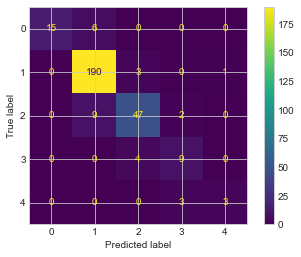

In [13]:
conf_mat = confusion_matrix(y_test, y_pred_rf)
conf_disp = ConfusionMatrixDisplay(conf_mat)
conf_disp.plot()
plt.show()

In [14]:
print(classification_report(y_test, y_pred_rf, digits=4))

              precision    recall  f1-score   support

         0.0     1.0000    0.7143    0.8333        21
         1.0     0.9268    0.9794    0.9524       194
         2.0     0.8704    0.8103    0.8393        58
         3.0     0.6429    0.6923    0.6667        13
         4.0     0.7500    0.5000    0.6000         6

    accuracy                         0.9041       292
   macro avg     0.8380    0.7393    0.7783       292
weighted avg     0.9046    0.9041    0.9014       292



Without feature engineering:
* weighted avg     0.8874    0.8870    0.8835       292

Without upsampling:
* weighted avg     0.8796    0.8801    0.8747       292

Without feature engineering and upsampling
* weighted avg     0.8780    0.8801    0.8751       292

With feature engineering and upsampling:
* weighted avg     0.9046    0.9041    0.9014       292

